# Определение перспективного тарифа для телеком-компании

## Описание проекта

«Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». В проекте предстоит провести предварительный анализ тарифов на выборке из 500 клиентов.
Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

**Стоимость услуг сверх тарифного пакета:**

минута разговора: 3 рубля

сообщение: 3 рубля

1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

**Стоимость услуг сверх тарифного пакета:**

минута разговора: 1 рубль

сообщение: 1 рубль

1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Предобработка данных

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math as mt
from functools import reduce

In [51]:
try:
    calls = pd.read_csv('/datasets/calls.csv') 
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv')
except:
    calls = pd.read_csv('calls.csv') 
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')

In [52]:
def info_data (data) :
    display(data.info(),
          data.head(),
          data.describe())    

### Данные по звонкам

Пропущенные звонки отображаются в датасете как звонки с нулевой продолжительностью

In [53]:
info_data(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


В последующей части проекта мы будем подсчитывать общее число потраченных минут пользователем за месяц. Значит данные сгруппируются по id пользователя и месяцам. Приведем данные таблицы call_date к типу даты. Данные представлены только за 2018 год, значит группировать можно только по номеру месяца. Каждое значение продолжительности  вызова округляется после его завершения, значит округлить данные необходимо до группировки.

In [54]:
def make_month_column (data, data_data):
    data_data = pd.to_datetime( data_data , format = '%Y-%m-%dT%H:%M:%S') # приводим данные в столбце call_date к типу данных дата
    data['month'] = data_data.dt.month
    # так как все данные будут группировать по месяцам, в датасетах будет нужно создавать столбец с датой, автоматизируем процесс
    
make_month_column (calls, calls['call_date'])    
calls['duration'] = np.ceil(calls['duration']) .astype('int') # округляем до целых минут

In [55]:
calls.head(10)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


In [56]:
calls_assemble = calls.loc[: , [ 'user_id', 'month', 'duration']]
calls_assemble = calls_assemble.pivot_table( index =['user_id','month'], values = 'duration', aggfunc = 'sum').reset_index()
calls_assemble.columns = ['user_id', 'month', 'calls_duration']

calls_assemble 

,user_id,month,calls_duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466
...,...,...,...
3169,1498,10,247
3170,1499,9,70
3171,1499,10,449
3172,1499,11,612


### Данные по интернет тарифу

In [57]:
info_data(internet)                                                                                           

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [58]:
make_month_column (internet, internet['session_date'])

internet_assemble = internet.loc[: , [ 'user_id', 'month', 'mb_used']]
internet_assemble = internet_assemble.pivot_table( index =['user_id','month'], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_assemble.columns = ['user_id', 'month', 'mb_used']

internet_assemble


,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


В 1 гигобайте 1024 мегобайта. По тарифу общая сумма за месяц округляется в бо́льшую сторону до гигобайта. Переведем МБ в ГБ и округлим 

###  Данные по сообщениям

In [59]:
info_data(messages) 
make_month_column (messages, messages['message_date'])

messages_assemble = messages.loc[: , [ 'user_id', 'month', 'id']]
messages_assemble = messages_assemble.pivot_table( index=['user_id','month'], values='id', aggfunc='count').reset_index()
messages_assemble.columns = ['user_id', 'month', 'messages_used']

messages_assemble

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,user_id,month,messages_used
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


###  Данные по пользователям

In [60]:
info_data(users)
users_assemble = users.loc[ : , ['user_id', 'city', 'tariff']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


 ###  Данные по тарифу

In [61]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [62]:
tariffs_2 = tariffs
tariffs_2['gb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs_2['gb_per_month_included'] = tariffs_2['gb_per_month_included'].astype('int64')

## Объединяем в общую таблицу

In [63]:
data_frames = [calls_assemble, messages_assemble, internet_assemble, users_assemble ]
df = reduce(lambda  left,right: pd.merge(left, right, on= ['user_id'],
                                            how='outer'), data_frames)

In [64]:
df['mb_used'] = internet_assemble['mb_used']/1024 # переводим мб в гб
df['mb_used'] =np.ceil(df['mb_used'])
df['mb_used'] = pd.array( df['mb_used'],  dtype='Int64')  # округляем до целого гб, как указано в тарифе
df = df.rename(columns = {'tariff':'tariff_name'})
df = df.drop(columns=['month_x', 'month_y'])
df['month'] = df['month'].astype('Int64')

In [65]:
df['mb_used'] = df['mb_used'].astype('float64')  # чтобы потом считать статистии в сводных таблицах

In [66]:
df = df.merge(tariffs_2, on='tariff_name')
df = df.rename( columns = {'mb_used':'gb_used' }) #так как ранее мы перевели из мб в гб
df = df.fillna(0) # заполняем на 0, так как это действительно 0 гб, смс, минут было использовано

In [67]:
df

,user_id,calls_duration,messages_used,month,gb_used,city,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,159.0,22.0,5,3.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
1,1000,159.0,22.0,6,23.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
2,1000,159.0,22.0,7,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
3,1000,159.0,22.0,8,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
4,1000,159.0,22.0,9,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207174,1489,0.0,35.0,9,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15
207175,1489,0.0,35.0,10,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15
207176,1489,0.0,35.0,11,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15
207177,1489,0.0,35.0,12,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15


In [68]:
def revenue (row):
    sms = (row ['messages_used'] - row['messages_included'])*row['rub_per_message']
    calls = (row ['calls_duration'] - row['minutes_included'])*row['rub_per_minute']
    internet = (row ['gb_used'] - row['gb_per_month_included'])*row['rub_per_gb']
    total = row ['rub_monthly_fee']
    for i in [sms,calls,internet]:
        if i>0:
            total += i
    return total
df['revenue'] = df.apply(revenue,axis = 1)
df

,user_id,calls_duration,messages_used,month,gb_used,city,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,revenue
0,1000,159.0,22.0,5,3.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
1,1000,159.0,22.0,6,23.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
2,1000,159.0,22.0,7,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
3,1000,159.0,22.0,8,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
4,1000,159.0,22.0,9,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,30,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207174,1489,0.0,35.0,9,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15,550.0
207175,1489,0.0,35.0,10,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15,550.0
207176,1489,0.0,35.0,11,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15,550.0
207177,1489,0.0,35.0,12,0.0,Санкт-Петербург,smart,50,15360,500,550,200,3,3,15,550.0


## Анализ поведения пользователей

### Проанализируем какое количество минут тратят пользователи разных тарифов

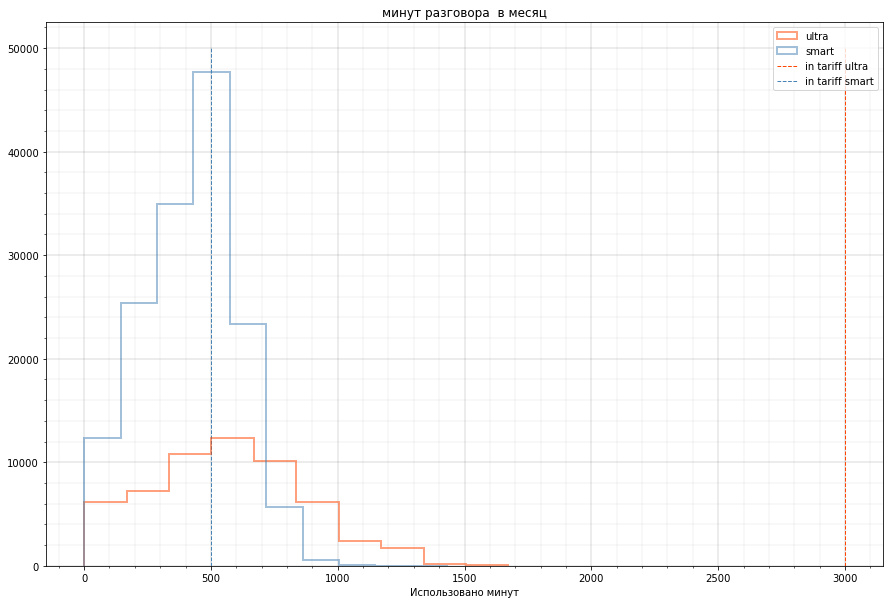

In [69]:
plt.figure(figsize=(15,10))
plt.hist(df[df['tariff_name'] == 'ultra']['calls_duration'], 
         bins = 10, alpha = 0.5, label = 'ultra', histtype='step', color='orangered', linewidth=2)
plt.hist(df[df['tariff_name'] == 'smart']['calls_duration'],
         bins = 10, alpha = 0.5, label = 'smart',  histtype='step', color='steelblue', linewidth=2)
plt.vlines(x=3000,  ymin=0, ymax=50000, label = 'in tariff ultra', color='orangered', linewidth=1, linestyle='--')
plt.vlines(x=500,  ymin=0, ymax=50000, label = 'in tariff smart', color='steelblue', linewidth=1, linestyle='--' )
plt.xlabel('Использовано минут')

plt.legend(loc = 'upper right')
plt.title('минут разговора  в месяц')
plt.grid(color='gray', linewidth=0.2)
plt.minorticks_on()
plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.3)
plt.grid(which='minor', color='gray', linewidth=0.1)
plt.show()

По графику видим, что в среднем пользователям тарифа Smart хватает кол-ва минут, заложенных в тарифе, есть небольшой положительный скос.
В то время как пользователи Ultra никогда не истрачивали свой пакет, такое кол-во минут избыточно.

In [96]:
def info_servisce (data, value):
    table = data.pivot_table(index= 'tariff_name', values= value, aggfunc= ['mean','median','std', 'var'])
    table.columns = table.columns.droplevel(1)
    table.columns = ['Среднее','Медиана', 'Стандартное отклонение', 'Дисперсия']
    return table

In [97]:
info_servisce( df, 'calls_duration')

,Среднее,Медиана,Стандартное отклонение,Дисперсия
tariff_name,,,,
smart,417.504609,437.0,183.774138,33772.933723
ultra,566.465139,553.0,300.311175,90186.801737


### Анализ использования интернета

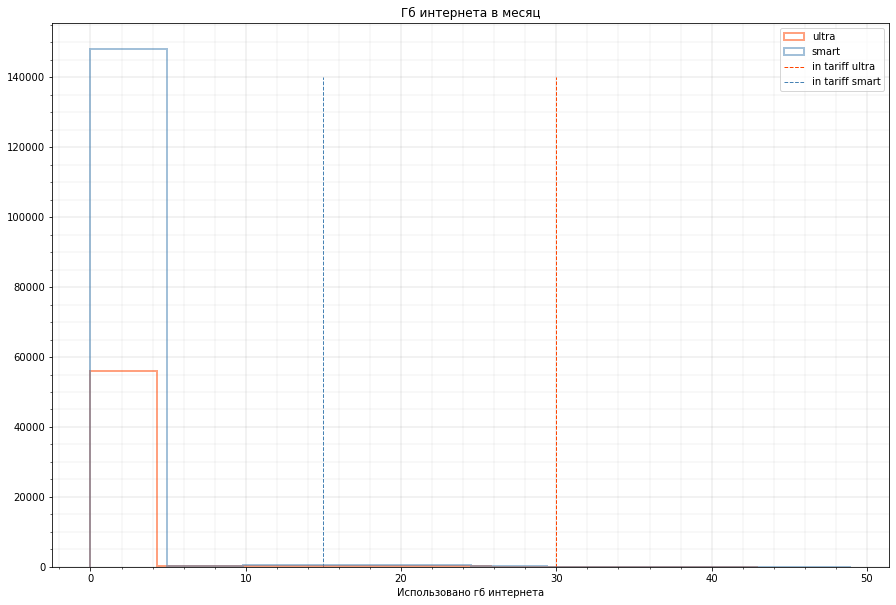

In [71]:
plt.figure(figsize=(15,10))
plt.hist(df[df['tariff_name'] == 'ultra']['gb_used'], 
         bins = 10, alpha = 0.5, label = 'ultra', histtype='step', color='orangered', linewidth=2)
plt.hist(df[df['tariff_name'] == 'smart']['gb_used'],
         bins = 10, alpha = 0.5, label = 'smart',  histtype='step', color='steelblue', linewidth=2)
plt.vlines(x=30,  ymin=0, ymax=140000, label = 'in tariff ultra', color='orangered', linewidth=1, linestyle='--')
plt.vlines(x=15,  ymin=0, ymax=140000, label = 'in tariff smart', color='steelblue',linewidth=1, linestyle='--' )
plt.xlabel('Использовано гб интернета')

plt.legend(loc = 'upper right')
plt.title('Гб интернета в месяц')
plt.minorticks_on()
plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.2)
plt.grid(which='minor', color='gray', linewidth=0.1)
plt.show()

Графики использования интернета пользователями тарифа Smart скошен вправо незначительно. Большинство пользователей используют до 5 гб интернета в месяц, что меньше тарифных пакетов. Линии симметрии графиков почти совпадают, значит независимо от тарифа люди используют примерно одинаковое кол-во гб.

In [72]:
use_more_internet = df[df['gb_used']> 5]

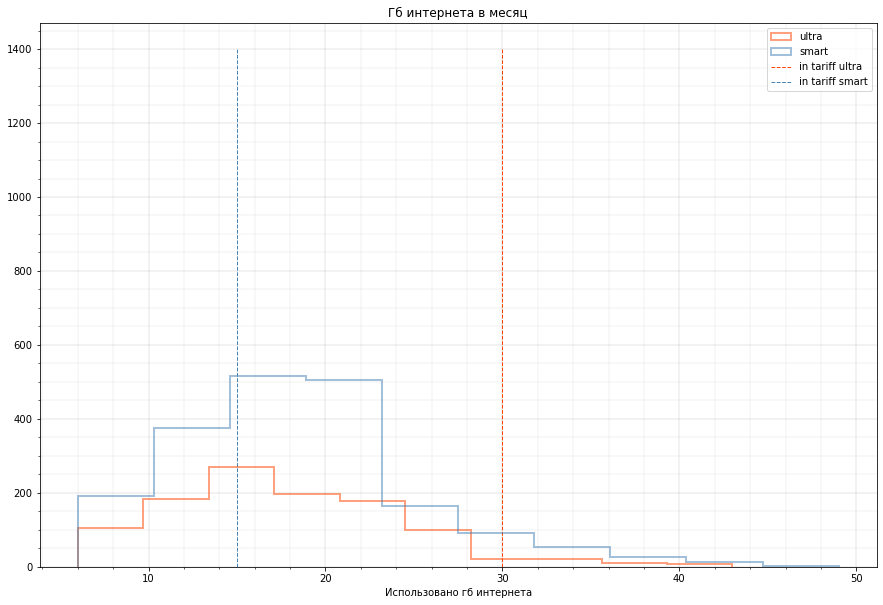

In [73]:
plt.figure(figsize=(15,10))
plt.hist(use_more_internet[use_more_internet['tariff_name'] == 'ultra']['gb_used'], 
         bins = 10, alpha = 0.5, label = 'ultra', histtype='step', color='orangered', linewidth=2)
plt.hist(use_more_internet[use_more_internet['tariff_name'] == 'smart']['gb_used'],
         bins = 10, alpha = 0.5, label = 'smart',  histtype='step', color='steelblue', linewidth=2)
plt.vlines(x=30,  ymin=0, ymax=1400, label = 'in tariff ultra', color='orangered', linewidth=1, linestyle='--')
plt.vlines(x=15,  ymin=0, ymax=1400, label = 'in tariff smart', color='steelblue',linewidth=1, linestyle='--' )
plt.xlabel('Использовано гб интернета')

plt.legend(loc = 'upper right')
plt.title('Гб интернета в месяц')
plt.minorticks_on()
plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.2)
plt.grid(which='minor', color='gray', linewidth=0.1)
plt.show()

Число людей, использующих интернет больше 5 гб за расчетный период, по сравнению с общей массой представляется крайне малочисленным

In [98]:
info_servisce( df, 'gb_used')

,Среднее,Медиана,Стандартное отклонение,Дисперсия
tariff_name,,,,
smart,0.239241,0.0,2.211427,4.890409
ultra,0.344825,0.0,2.608019,6.801763


### Анализ использования смс

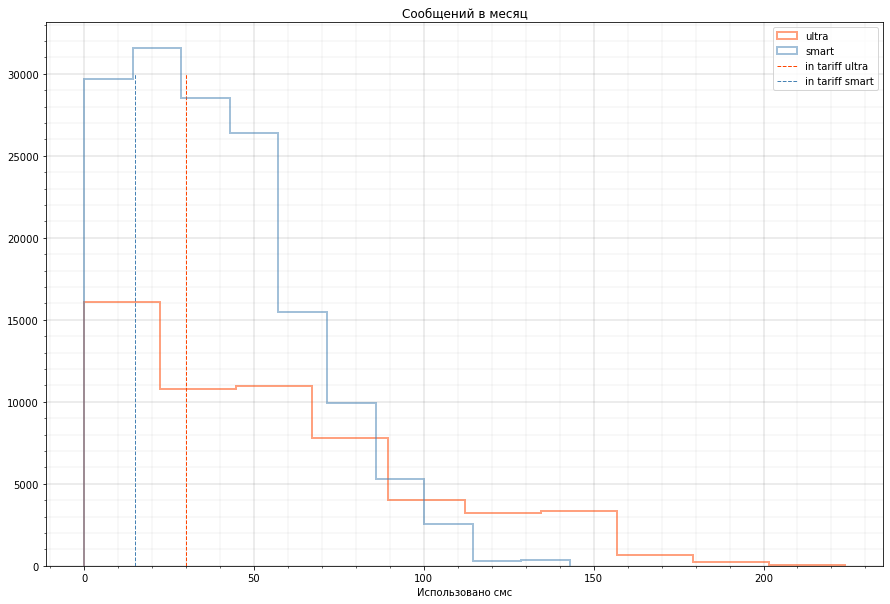

In [76]:
plt.figure(figsize=(15,10))
plt.hist(df[df['tariff_name'] == 'ultra']['messages_used'], 
         bins = 10, alpha = 0.5, label = 'ultra', histtype='step', color='orangered', linewidth=2)
plt.hist(df[df['tariff_name'] == 'smart']['messages_used'],
         bins = 10, alpha = 0.5, label = 'smart',  histtype='step', color='steelblue', linewidth=2)
plt.vlines(x=30,  ymin=0, ymax=30000, label = 'in tariff ultra', color='orangered', linewidth=1, linestyle='--')
plt.vlines(x=15,  ymin=0, ymax=30000, label = 'in tariff smart', color='steelblue',linewidth=1, linestyle='--' )
plt.xlabel('Использовано смс')

plt.legend(loc = 'upper right')
plt.title('Сообщений в месяц')
plt.minorticks_on()
plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.3)
plt.grid(which='minor', color='gray', linewidth=0.1)
plt.show()

info_servisce( df, 'gb_used')Графики использования смс пользователями разных тарифов сильно скошены вправо. Кол-ва смс, включенного в тарифы, многим не хватает

In [99]:
info_servisce( df, 'messages_used')

,Среднее,Медиана,Стандартное отклонение,Дисперсия
tariff_name,,,,
smart,38.847231,35.0,25.961233,673.985599
ultra,55.530590,48.0,43.102651,1857.838505


### Анализ выручки от разных тарифов

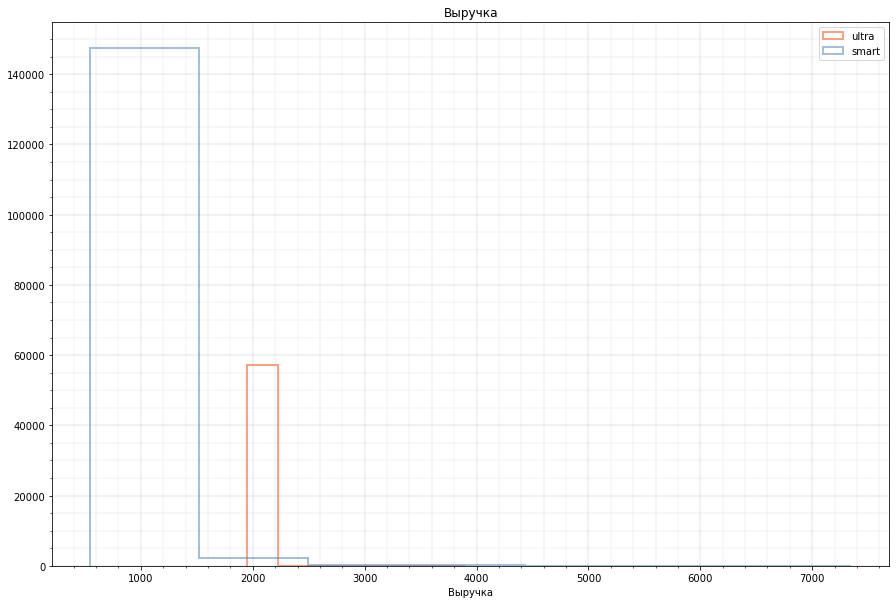

In [78]:
plt.figure(figsize=(15,10))
plt.hist(df[df['tariff_name'] == 'ultra']['revenue'], 
         bins = 7, alpha = 0.5, label = 'ultra', histtype='step', color='orangered', linewidth=2)
plt.hist(df[df['tariff_name'] == 'smart']['revenue'],
         bins = 7, alpha = 0.5, label = 'smart',  histtype='step', color='steelblue', linewidth=2)

plt.xlabel('Выручка')

plt.legend(loc = 'upper right')
plt.title('Выручка')
plt.minorticks_on()
plt.grid(which='major',
        color = 'gray', 
        linewidth = 0.2)
plt.grid(which='minor', color='gray', linewidth=0.1)
plt.show()

In [100]:
info_servisce( df, 'revenue')

,Среднее,Медиана,Стандартное отклонение,Дисперсия
tariff_name,,,,
smart,694.711791,559.0,283.362486,80294.298337
ultra,1950.614259,1950.0,27.055896,732.021482


В целом выручка от пользователей тарифа Smart больше, но среднее выручки больше у пользователей тарифа Ultra. Следовательно, для компании было бы выгоднее увеличивать соотношение числа пользователей  Ultra к пользователям второго тарифа

## Проверяем гипотезы

### Гипотеза 1

**Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**

**Проводя двухсотронний тест, зададим нулевую гипотезу** \
[Но] = "Выручка пользователей тарифов «Ультра» и «Смарт» равны" \
**и альтернативную**\
[На] = "Выручка пользователей тарифов «Ультра» и «Смарт»  НЕ равны" 

Таким образом с помощью теста мы будем проверять равенство среднего совокупностей по выборкам (так как мы изначально работаем с выборкой, в которой имеем выборки из двух совокупностей - пользователей Smart и пользователей Ultra, одна из которых больше, так же как и ее выборка )

По итогу **Заданная нам гипотеза отвергнется, если выдвинутая гипотеза [Но]  нет** 

In [29]:

smart = df[df['tariff_name']=='smart']['revenue'] 
ultra = df[df['tariff_name']=='ultra']['revenue'] 
# задаем пороговое значение
alpha = 0.05
 
results = st.ttest_ind(smart, ultra, equal_var=False) # equal_var = False так как дисперсии не равны

 
print('p-значение: ', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение:  0.0
Отвергаем нулевую гипотезу


#### Вывод

 **Не отвергаем гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

### Гипотеза 2

**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**

Так же как и с первой гипотезой выдвинем нулевую гипотезу, обратную заданной, тогда мы отвергаем ее, если среднее двух выборок отличается в меньшую или большую сторону, а заданная в этом случае не отвергается 

Но = средняя выручка пользователей из Москвы равна выручке пользователей из других регионов \
На = средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [30]:
moscow = df[df['city']=='Москва']['revenue'] 
not_moscow = df[df['city']!='Москва']['revenue'] 
# задаем пороговое значение
alpha = 0.05
 
results = st.ttest_ind(moscow, not_moscow, equal_var=False) # equal_var = False так как дисперсии не равны

 
print('p-значение: ', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу") 

p-значение:  0.0
Отвергаем нулевую гипотезу


#### Вывод

Исходя из полученных результатов, мы не отвергаем нулевую гипотезу, тогда мы **НЕ можем утверждать**, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

## Общий вывод

Гипотеза 1 о том, что \
"**Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается**" не отвергается, \
в то время как Гипотеза 2  \
"**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**" по результатам теста выглядит ошибочной.


Больше средств компании приносит тариф Smart, но предпочтительно увеличивать процент пользователей тарифа Ultra по отношению к пользователям Smart, так как средняя выручка от них выше. В ходе анализа используемых услуг, было выявлено, что большинству клиентов сильно не хватает заданных в тарифе количества сообщений. Количество минут разговора и гб интернета в тарифе Ultra избыточно. Возможно, если сократить в  пакете эти услуги и увеличить число смс, тариф Ultra станет привлекательнее. Тогда часть людей использующих тариф Smart перейдут на Ultra, так же этим тарифом заинтересуются новые пользователи, как более отвечающим на спрос. \
Так же можно увеличить стоимость тарифа Smart, но добавить число смс, так как большая часть докупает эту услугу, соответственно ежемесячно платят сверх тарифа.